# Signal Creation Pipeline

In [1]:
%load_ext autoreload
%autoreload 2

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from modules.data_utils import load_reddit_data, load_bitcoin_data
from modules.data_cleaning import preprocess_data
from modules.sentiment_analysis import get_roberta_checkpoint

## Load and clean data

In [3]:
df = load_reddit_data()
df_price = load_bitcoin_data()

In [4]:
df = preprocess_data(df)

## Sentiment Analysis

In [5]:
# df = get_roberta_sentiment(df)

In [6]:
# get checkpoint
sentiment_roberta = get_roberta_checkpoint()

# merge sentiment
df = pd.merge(df, sentiment_roberta, how="left", on="submission")
df = df.set_index("datetime")

## Relevance filtering

In [10]:
# LDA filter
topic_keywords = pd.read_csv("topic_keywords.csv")
trading_keywords = topic_keywords.loc[topic_keywords["Topic"]=="Topic 2", "Keyword"].values

In [11]:
com_filter = (df["num_comments"] > 100)
lda_filter = df["selftext"].str.lower().str.contains("|".join(trading_keywords))

In [12]:
(lda_filter).sum(), (com_filter).sum(), (com_filter & lda_filter).sum()

(11048, 714, 571)

In [13]:
print(df.shape)
df_lda = df.loc[lda_filter].copy() # filter on LDA topics
print(df_lda.shape)

(15582, 27)
(11048, 27)


In [72]:
np.corrcoef(df_lda["selftext"].apply(len), df_lda["negative_score"])

array([[ 1.        , -0.03859161],
       [-0.03859161,  1.        ]])

In [68]:
d = df_lda.loc[df_lda["selftext"].apply(len)<=300, ["submission", "selftext", "positive_score", "negative_score"]].sample(5)
d

,submission,selftext,positive_score,negative_score
datetime,,,,
2022-12-17 01:34:32,znuwn7,Can Crypto Exchanges Survive The Bear Market?\nAccording to Finbold. A total of 25 crypto exchanges closed down by July 2022 during the bear market. The exchanges that shut shop were smaller and newly launched platforms that couldn’t sustaining losses.\n\n,0.000000,0.67487
2022-05-11 01:13:02,umxvgg,"Trying to be a whole coiner\nI can't wait for the day way in the future when my grandkids ask, ""Grandpa, tell us the story again of how you managed to get one whole Bitcoin.""",0.000000,0.00000
2022-01-25 23:19:24,scquwo,GBTC after hours today GLITCH?\nThe after hours price is up like crazy for gbtc and ethe. I recall this happening before???,0.997849,0.00000
2022-09-22 14:40:56,xl39c9,Nuclear weapons\nWhat would happen to bitcoin if Putin use nuclear weapon?,0.000000,0.00000
2022-08-09 10:07:02,wjzg8a,"Whatbattracted you to ₿itcoin?\nI was thinking about it earlier today for what about Bitcoin is it that I like so much.\n\nIt's a number of things, but really I think it's my punk rock heart from my younger days when I was anti government, worried about the NWO and ect. that really hooked me in. Lol",0.000000,0.00000


In [47]:
d = df_lda.sample(5)[["submission", "selftext", "positive_score", "negative_score"]]
d

,submission,selftext,positive_score,negative_score
datetime,,,,
2022-07-12 09:37:15,vx777y,Bitcoin\nWhat are people's thoughts on Bitcoin...,0.000000,0.000000
2022-02-20 10:17:31,swy860,Question to anyone from El Salvador.\nSo I jus...,0.000000,0.590053
2022-03-19 11:07:50,thsyuo,El Salvador - a powerful military nation?\nI w...,0.995542,0.000000
2022-12-03 20:17:29,zbpija,Best counterarguments available to The Fiat St...,0.000000,0.000000
2022-08-30 23:53:57,x1yhtx,adoption feedback loops\n1. number go up and m...,0.998115,0.000000


In [69]:
d.to_csv("sample5.csv")

datetime
2022-07-12 09:37:15      56
2022-02-20 10:17:31     684
2022-03-19 11:07:50    1808
2022-12-03 20:17:29    1741
2022-08-30 23:53:57     612
Name: selftext, dtype: int64

In [53]:
d

,submission,selftext,positive_score,negative_score
datetime,,,,
2022-07-12 09:37:15,vx777y,Bitcoin\nWhat are people's thoughts on Bitcoin right now?,0.000000,0.000000
2022-02-20 10:17:31,swy860,"Question to anyone from El Salvador.\nSo I just [listened to this podcast]( stating that the % of Salvadorians with access to financial services stagnated for years of supposed 'help' from the IMF, but within 4 months of adopting bitcoin as legal tender it jumped from 30% to 60%.\n\nDo you know anyone personally who were totally excluded from financial services before, and now have access to it because of bitcoin? Most Salvadorians on this forum are already fluent in English, and much more likely to already be in a somewhat privileged situation before the adoption of bitcoin. It's all great but I'd love to hear about the people most affected, but whom we almost never hear about.",0.000000,0.590053
2022-03-19 11:07:50,thsyuo,"El Salvador - a powerful military nation?\nI was thinking about El Salvador and about how quickly my impression of this country has changed over the course of the last year. I remember my previous impression of the country (on the rare occasions I ever would have even thought about it) - was just poverty, crime, cartels and drugs, etc.\n\nSuddenly with the announcement last year - in my mind, it's the most enlightened country on the planet. Nayib Bukele become both a true here as well as someone I really relate to on a 'personal'/philosophical level. The difference over the course of a year is almost a kind of cognitive dissonance when I deeply reflect (very 2022).\n\nFollowing on from these musings, it occurred to me - just how secure the country of El Salvador is now - surprisingly e...",0.995542,0.000000
2022-12-03 20:17:29,zbpija,"Best counterarguments available to The Fiat Standard and The Bitcoin Standard?\nI'm not sure how exactly I began down this bitcoin/Austrian economics rabbit hole, but about a week ago it led me to two fantastic, yet very distressing books, The Fiat Standard and The Bitcoin Standard, both written by Saifedean Ammous. I'm kind of assuming that these books are well known amongst the bitcoin community - I apologize if that's not actually the case - the gist is basically fiat money = trash, bitcoin = ""hard"" money = good, although it obviously goes into a lot more depth than that. Frankly, I have felt very out of my depth reading these books and trying to think about economics this past week or so. I am able to read the arguments presented and find them compelling and see the logic in them b...",0.000000,0.000000
2022-08-30 23:53:57,x1yhtx,"adoption feedback loops\n1. number go up and more people talk to others and they join in\n2. the more people hodl the more stable the price (in fiat trash) is and that leads to more people joining the network\n3. the more miners the safer the network becomes\n4. as the wealth of early investors grow the more they have to spend on employing those to develope security options hardware (hardware wallets, and multisig UX), layer 2 and 3 improvements/additions, etc\n5. the bigger Bitcoin becomes the more capitol and human creativity enters the space which all leads right back in a loop of adoption. exciting times!",0.998115,0.000000


In [48]:
from modules.utils import set_pandas_display_options
set_pandas_display_options()

## Sentiment Signal

In [25]:
def get_alpha(df: pd.DataFrame, lag: str = "24h"):
    df["rolling_positive_score"] = df["positive_score"].rolling(lag).sum()
    df["rolling_negative_score"] = df["negative_score"].rolling(lag).sum()
    df["alpha"] = (df["rolling_positive_score"] - df["rolling_negative_score"]) / (df["rolling_positive_score"] + df["rolling_negative_score"] + 1e-4)
    return df

In [26]:
df = get_alpha(df)
df_lda = get_alpha(df_lda)

<Axes: >

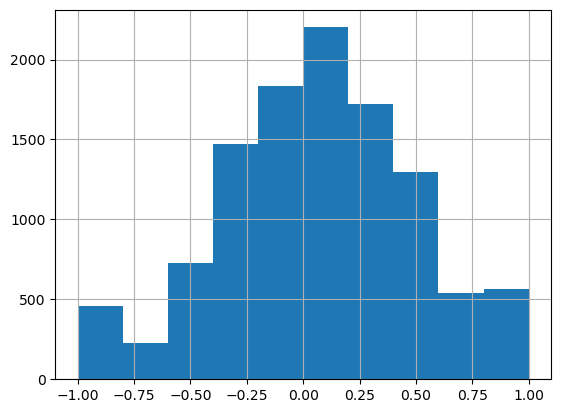

In [27]:
df_lda["alpha"].hist()

# Price prediction

In [22]:
df_date_col_name = "created"
df_price_date_col_name = "datetime"

df[df_date_col_name] = pd.to_datetime(df[df_date_col_name])
df_lda[df_date_col_name] = pd.to_datetime(df_lda[df_date_col_name])
df_price[df_price_date_col_name] = pd.to_datetime(df_price[df_price_date_col_name])

In [23]:
# Sort df2 by timestamp to ensure binary search can be applied
df = df.sort_values(by='datetime')
df_lda = df_lda.sort_values(by='datetime')
df["datetime"] = df.index
df_lda["datetime"] = df_lda.index

# Method to find the closest timestamp in df2 that is less than or equal to the timestamp in df1
def find_closest_below(row, df):
    # Filter df2 to only include rows where the timestamp is less than or equal to the current row's timestamp in df1
    eligible_signals = df[df['datetime'] <= row['datetime']]
    # If there are no eligible timestamps in df2, return NaN or some default value
    if eligible_signals.empty:
        return pd.NA
    else:
        # Return the signal of the closest timestamp
        return eligible_signals.iloc[-1]['alpha']

# Apply the function to df1
df_price['signal'] = df_price.apply(find_closest_below, df=df, axis=1)
df_price['signal_lda'] = df_price.apply(find_closest_below, df=df_lda, axis=1)

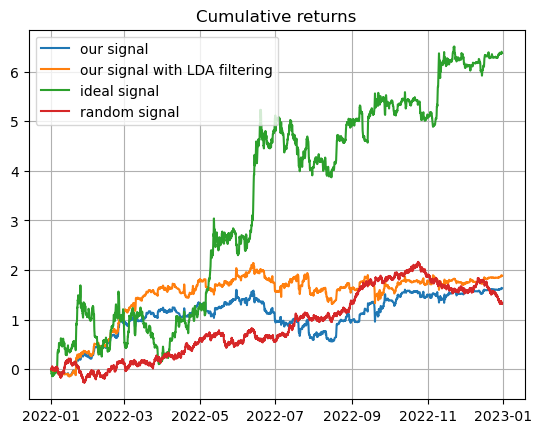

In [55]:
df_price["real"] = df_price[f"perf_lag5"] * df_price["signal"]
df_price["real_lda"] = df_price[f"perf_lag5"] * df_price["signal_lda"]

# df_price["random_signal"] = np.random.uniform(low=-1, high=1, size=len(df_price))
df_price["random_signal"] = np.random.normal(0, 0.01, size=len(df_price))

plt.plot(df_price["datetime"], df_price["real"].cumsum(), label="our signal")
plt.plot(df_price["datetime"], df_price["real_lda"].cumsum(), label="our signal with LDA filtering")
plt.plot(df_price["datetime"], df_price[f"perf_lag5"].cumsum(), label="ideal signal") # TODO: should we square it?
plt.plot(df_price["datetime"], df_price["random_signal"].cumsum(), label="random signal")

plt.title("Cumulative returns")
plt.grid()
plt.legend()

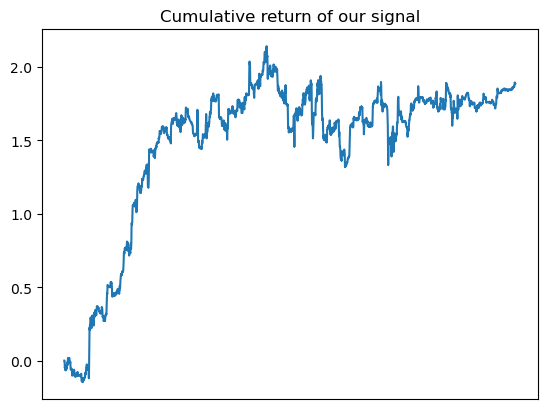

In [139]:
lag = 5
df_price["real"] = df_price[f"perf_{lag}"] * df_price["signal"]


plt.plot(df_price["datetime"],df_price["real"].cumsum())
plt.title("Cumulative return of our signal")
plt.xticks([])
plt.show()

#### Bitcoin vs. Sentiment signal

Text(0.5, 1.0, 'Bitcoin price 2022')

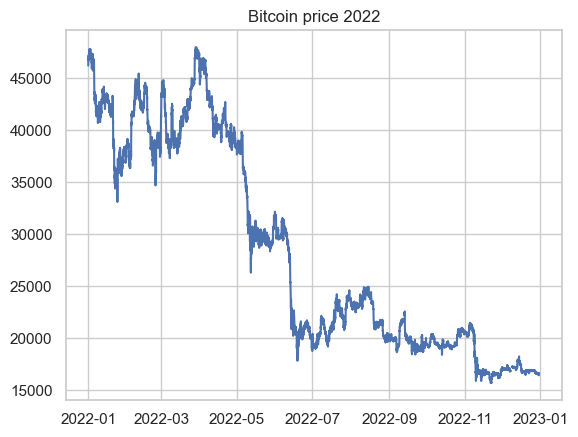

In [41]:
plt.plot(df_price["datetime"], df_price["open"])
plt.title("Bitcoin price 2022")

In [54]:
df.loc[df["author"].str.contains("bot"), "author"].unique()

array(['bot-repost-bot', 'solar_robot', 'Im_not_a_robot_8634', 'botolo',
       'Gregsbot', 'mrrobbottt', 'mulebotte', 'robotvoxy',
       'MonkeySoapRobotz', 'radarbot', 'DCARobot', 'toyrobotics',
       'TheRobotDr', 'therobotnipple'], dtype=object)

In [57]:
df["author"].nunique()

9819

In [47]:
df_price[["signal", "perf_5"]].isna().sum()

signal     1
perf_5    57
dtype: int64

In [49]:
df_price[["signal", "perf_5"]].dropna().corr()

,signal,perf_5
signal,1.000000,0.018753
perf_5,0.018753,1.000000


<Axes: >

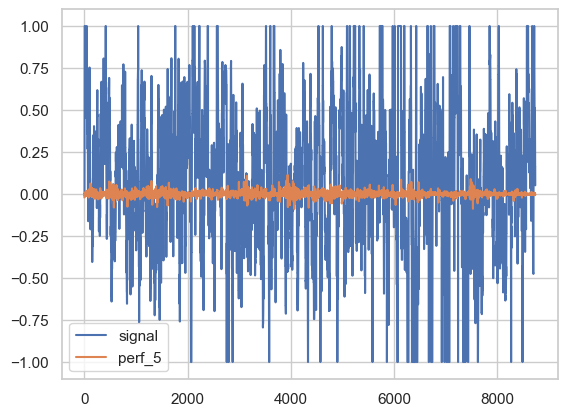

In [52]:
df_price[["signal", "perf_5"]].dropna().plot()

In [106]:
filter = df["selftext"].str.contains("http")
df.loc[filter, "selftext"].sample(1)

11071    [https://www.forbes.com/sites/markkantrowitz/2...
Name: selftext, dtype: object

In [107]:
df["selftext"].str.startswith("http|[http", regex=True).sum() / df.shape[0]

0.0